In [43]:
%pip install transformers datasets scikit-learn matplotlib seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# 2. Imports
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Train
er, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np


In [45]:
# Load your dataset
df = pd.read_csv("fewshot_dataset.csv")  # Make sure it has 'crimeadditionalinfo' and 'category' columns
df = df.dropna(subset=['crimeaditionalinfo', 'category'])

print(df.head())

In [46]:
print(df.head())

                category sub_category  \
0  Any Other Cyber Crime        Other   
1  Any Other Cyber Crime        Other   
2  Any Other Cyber Crime        Other   
3  Any Other Cyber Crime        Other   
4  Any Other Cyber Crime        Other   

                                  crimeaditionalinfo  
0  I am getting harrassed by some loan agent actu...  
1  I Rajender Pal Malhotra am the Authorized repr...  
2  I Mukesh Kumar  lured into a naked on screen v...  
3  I was order it on Amazon and we receive empty ...  
4  Dear SirMadam\r\nUnsuccessful transaction mone...  


In [47]:
# 4. Subset + label encode
df = df.sample(n=min(3000, len(df)), random_state=42).reset_index(drop=True)

labels = df['category'].unique().tolist()
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}
df['label'] = df['category'].map(label2id)


In [48]:
# 5. Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['crimeaditionalinfo'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

In [49]:
# 6. Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)


In [50]:
# 7. Dataset wrapper
class ComplaintDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}
    def __len__(self):
        return len(self.labels)

train_dataset = ComplaintDataset(train_encodings, train_labels)
val_dataset = ComplaintDataset(val_encodings, val_labels)

In [51]:
# 8. Model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased", num_labels=len(labels)
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
# 9. Metrics
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds)
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./results_bert",
    eval_steps=1,  # Evaluate every epoch
    save_steps=1,  # Save every epoch
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir="./logs",
    logging_steps=10,
)

In [54]:
# 11. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer)
)

C:\Users\Vaibh\AppData\Local\Temp\ipykernel_17380\437854987.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [55]:

# 12. Train
trainer.train()


Step,Training Loss
10,2.633000
20,2.553300


TrainOutput(global_step=21, training_loss=2.590357848576137, metrics={'train_runtime': 206.7663, 'train_samples_per_second': 0.813, 'train_steps_per_second': 0.102, 'total_flos': 5564821377024.0, 'train_loss': 2.590357848576137, 'epoch': 3.0})

In [56]:
from accelerate import Accelerator
accelerator = Accelerator()


In [57]:

# 13. Evaluate
preds = trainer.predict(val_dataset)
y_true = val_labels
y_pred = np.argmax(preds.predictions, axis=1)

In [58]:
# 14. Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))


Classification Report:

                                                      precision    recall  f1-score   support

                                     Cyber Terrorism       0.00      0.00      0.00       1.0
                               Any Other Cyber Crime       0.00      0.00      0.00       0.0
               Online and Social Media Related Crime       0.00      0.00      0.00       1.0
                                          Ransomware       0.00      0.00      0.00       1.0
                      Cyber Attack/ Dependent Crimes       0.00      0.00      0.00       2.0
                                Cryptocurrency Crime       0.00      0.00      0.00       1.0
                            Online Cyber Trafficking       0.00      0.00      0.00       2.0
Child Pornography CPChild Sexual Abuse Material CSAM       0.00      0.00      0.00       0.0
                           Sexually Obscene material       0.00      0.00      0.00       1.0
                               Sexu

c:\Users\Vaibh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vaibh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vaibh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [59]:
from sklearn.metrics import classification_report

unique_labels = sorted(list(set(y_true)))
print("Classification Report:\n")
print(classification_report(y_true, y_pred, labels=unique_labels, target_names=[str(l) for l in unique_labels]))


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       2.0
           5       0.00      0.00      0.00       1.0
           6       0.00      0.00      0.00       2.0
           8       0.00      0.00      0.00       1.0
           9       0.00      0.00      0.00       1.0
          10       0.00      0.00      0.00       1.0
          11       0.00      0.00      0.00       2.0
          12       0.00      0.00      0.00       1.0

   micro avg       0.00      0.00      0.00      14.0
   macro avg       0.00      0.00      0.00      14.0
weighted avg       0.00      0.00      0.00      14.0



c:\Users\Vaibh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vaibh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vaibh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

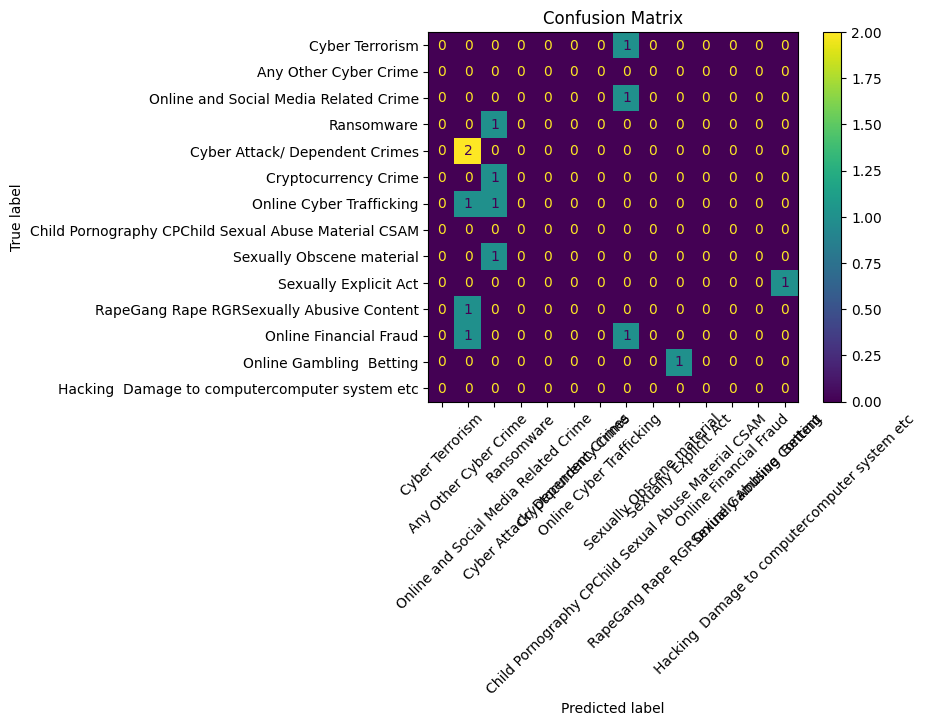

In [60]:

# 15. Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()